**Setup & Imports**

In [1]:
!pip install -q rasterio segmentation-models-pytorch==0.3.3 torchmetrics==1.3.0

# Core
import os
from glob import glob
from pathlib import Path

# Numerical + Plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# TIFF Handling
import rasterio
from rasterio.plot import show

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import random

# Segmentation Models (U-Net, UNet++, DeepLabV3+, MAnet)
import segmentation_models_pytorch as smp

# Metrics
from torchmetrics.functional import jaccard_index

# Utility
from PIL import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.6 MB/s eta 0:00:00
Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.6 MB/s eta 0:00:00


**Mount Google Drive & Locate TIFF Images**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/RGB_Prep_Demo")

tif_paths = sorted(DATA_DIR.glob("*.tif"))
print(f"Number of TIFF files: {len(tif_paths)}")
for p in tif_paths[:5]:
    print(p.name)


Mounted at /content/drive
Number of TIFF files: 15
930645_se.tif
930650_ne.tif
930660_se.tif
930665_se.tif
930670_ne.tif


**Load TIFF & Compute NDVI**

In [3]:
def load_tif(path):
    """Return image array with shape (bands, H, W) and the raster profile."""
    with rasterio.open(path) as src:
        img = src.read()          # (bands, H, W)
        profile = src.profile
    return img, profile


def compute_ndvi(bands, red_idx=1, nir_idx=4):
    """
    Compute NDVI from a 4-band image.
    red_idx, nir_idx are 1-based band indices (R,G,B,NIR).
    """
    red = bands[red_idx - 1].astype("float32")
    nir = bands[nir_idx - 1].astype("float32")

    ndvi = (nir - red) / (nir + red + 1e-6)
    ndvi = np.clip(ndvi, -1.0, 1.0)
    return ndvi


**Visualize RGB and NDVI for a Sample TIFF**

Using sample: 930645_se.tif
Bands, H, W: (4, 5000, 5000)
NDVI range: -0.7487743496894836 0.8250192403793335


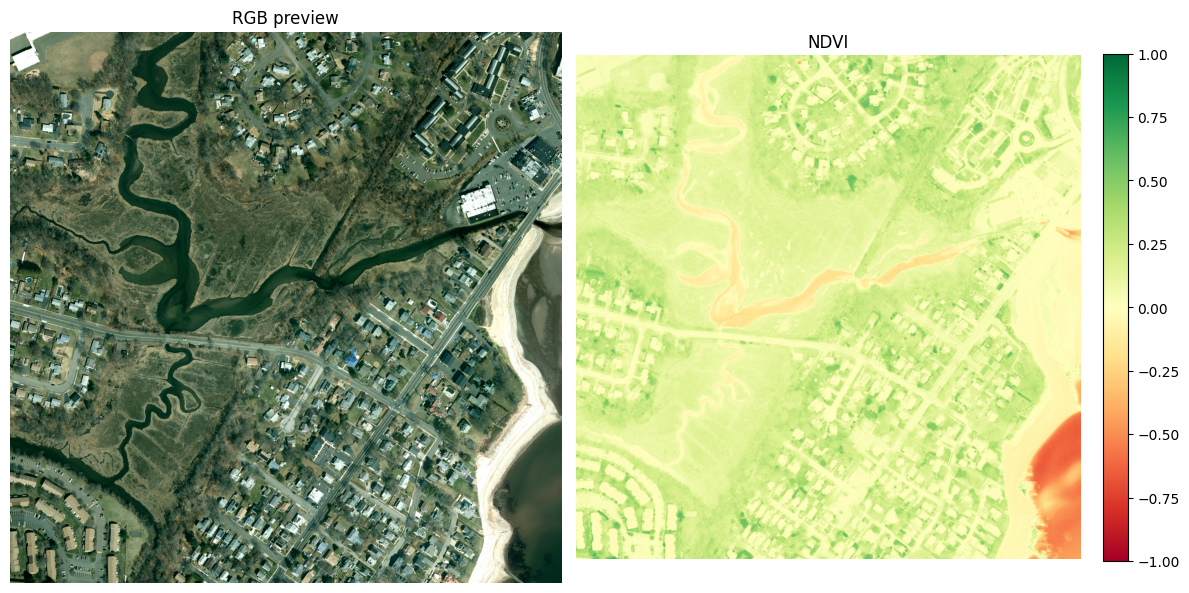

In [4]:
sample_path = tif_paths[0]
print("Using sample:", sample_path.name)

bands, profile = load_tif(sample_path)
print("Bands, H, W:", bands.shape)

ndvi = compute_ndvi(bands)
print("NDVI range:", float(ndvi.min()), float(ndvi.max()))

# Build an RGB preview from the first three bands
rgb = np.transpose(bands[:3], (1, 2, 0))
rgb_min, rgb_max = np.percentile(rgb, (2, 98))
rgb_disp = np.clip((rgb - rgb_min) / (rgb_max - rgb_min + 1e-6), 0, 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(rgb_disp)
axs[0].set_title("RGB preview")
axs[0].axis("off")

# NDVI with fixed [-1, 1] scale
im = axs[1].imshow(ndvi, cmap="RdYlGn", vmin=-1.0, vmax=1.0)
axs[1].set_title("NDVI")
axs[1].axis("off")

fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



**Mask + Overlay**

Mask classes: [0 1 2 3]


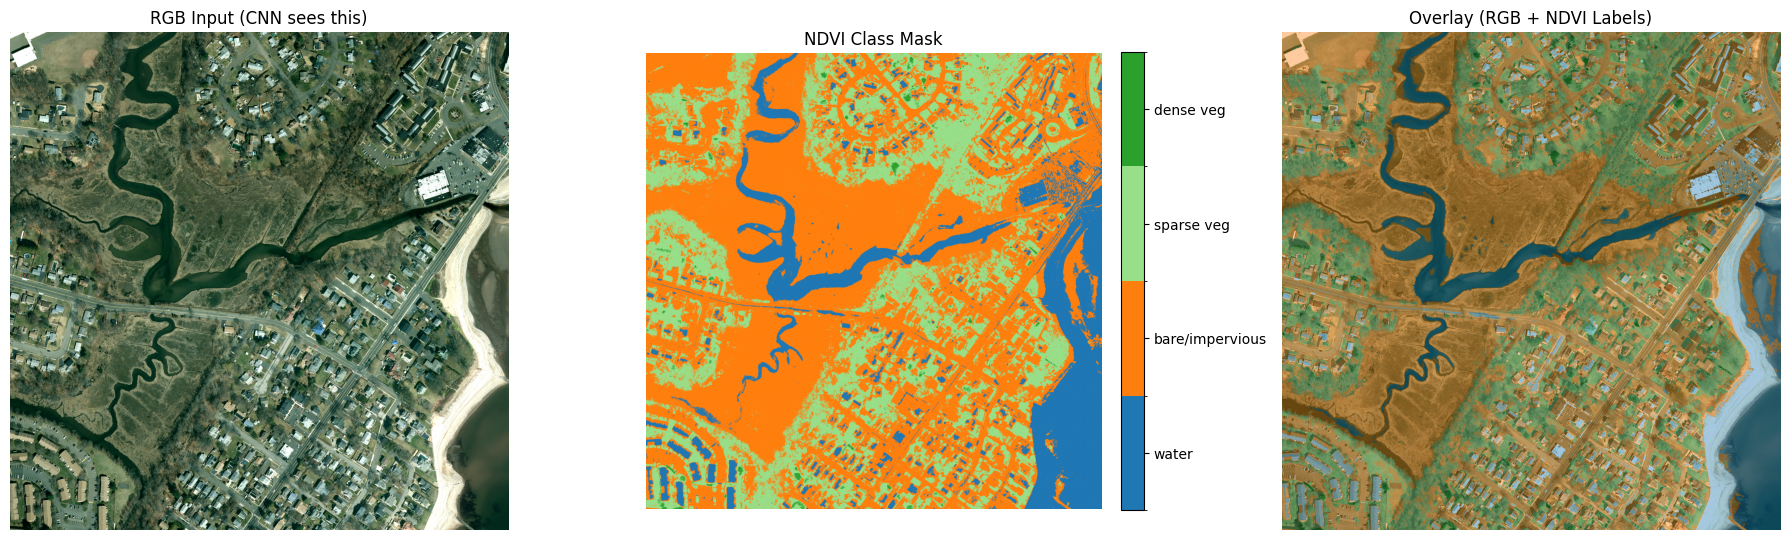

In [5]:
# NDVI -> class mask using threshold table:
# 0: water          (NDVI < 0.0)
# 1: bare/impervious (0.0 - 0.2)
# 2: sparse veg      (0.2 - 0.5)
# 3: dense veg       (0.5 - 1.0)

def ndvi_to_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)

    mask[ndvi < 0.0] = 0
    mask[(ndvi >= 0.0) & (ndvi < 0.2)] = 1
    mask[(ndvi >= 0.2) & (ndvi < 0.5)] = 2
    mask[ndvi >= 0.5] = 3

    return mask

mask = ndvi_to_mask(ndvi)
print("Mask classes:", np.unique(mask))

# Colormap: 0 blue (water), 1 orange (impervious), 2 light green, 3 dark green
class_colors = [
    "#1f77b4",  # 0 water
    "#ff7f0e",  # 1 bare/impervious
    "#98df8a",  # 2 sparse veg
    "#2ca02c",  # 3 dense veg
]

cmap_classes = ListedColormap(class_colors)
norm_classes = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5],
                            ncolors=len(class_colors))

# rgb_disp from previous cell (already 0–1)
rgb_norm = rgb_disp
mask_rgb = cmap_classes(mask)[..., :3]
overlay = 0.6 * rgb_norm + 0.4 * mask_rgb
overlay = np.clip(overlay, 0, 1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(rgb_norm)
axs[0].set_title("RGB Input (CNN sees this)")
axs[0].axis("off")

im2 = axs[1].imshow(mask, cmap=cmap_classes, norm=norm_classes)
axs[1].set_title("NDVI Class Mask")
axs[1].axis("off")

axs[2].imshow(overlay)
axs[2].set_title("Overlay (RGB + NDVI Labels)")
axs[2].axis("off")

cbar = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04,
                    ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(["water", "bare/impervious",
                         "sparse veg", "dense veg"])

plt.tight_layout()
plt.show()


**NDVI to Integer Mask**

In [6]:
# 0: water (NDVI < 0.0)
# 1: bare/impervious (0.0 - 0.2)
# 2: sparse veg (0.2 - 0.5)
# 3: dense veg (>= 0.5)

def ndvi_to_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)

    mask[ndvi < 0.0] = 0
    mask[(ndvi >= 0.0) & (ndvi < 0.2)] = 1
    mask[(ndvi >= 0.2) & (ndvi < 0.5)] = 2
    mask[ndvi >= 0.5] = 3

    return mask

In [16]:
# Output directories
BASE_OUT = Path("/content/drive/MyDrive/ResearchProject (1)/processed_output")
NDVI_DIR = BASE_OUT / "ndvi_arrays"
MASK_DIR = BASE_OUT / "ndvi_masks"

NDVI_DIR.mkdir(parents=True, exist_ok=True)
MASK_DIR.mkdir(parents=True, exist_ok=True)

print("Saving NDVI arrays to:", NDVI_DIR)
print("Saving masks to:", MASK_DIR)

for tif_path in tif_paths:
    bands, profile = load_tif(tif_path)
    ndvi = compute_ndvi(bands)
    mask = ndvi_to_mask(ndvi)

    stem = tif_path.stem

    # Save NDVI as .npy (float32)
    np.save(NDVI_DIR / f"{stem}_ndvi.npy", ndvi.astype("float32"))

    # Save mask as PNG (uint8)
    mask_img = Image.fromarray(mask.astype(np.uint8))
    mask_img.save(MASK_DIR / f"{stem}_mask.png")

    print(f"Processed {stem} | classes: {np.unique(mask)}")

print("Done. Total files processed:", len(tif_paths))

Saving NDVI arrays to: /content/drive/MyDrive/ResearchProject (1)/processed_output/ndvi_arrays
Saving masks to: /content/drive/MyDrive/ResearchProject (1)/processed_output/ndvi_masks
Processed 930645_se | classes: [0 1 2 3]
Processed 930650_ne | classes: [0 1 2 3]
Processed 930660_se | classes: [0 1 2 3]
Processed 930665_se | classes: [0 1 2 3]
Processed 930670_ne | classes: [1 2 3]
Processed 930675_se | classes: [0 1 2 3]
Processed 935645_nw | classes: [0 1 2 3]
Processed 935645_se | classes: [0 1 2 3]
Processed 935645_sw | classes: [0 1 2 3]
Processed 935650_se | classes: [0 1 2 3]
Processed 935660_nw | classes: [0 1 2 3]
Processed 935665_ne | classes: [0 1 2 3]
Processed 940665_ne | classes: [0 1 2 3]
Processed 945655_se | classes: [0 1 2 3]
Processed 950660_se | classes: [0 1]
Done. Total files processed: 15


**Tiling 512 x 512 Patches**

In [17]:
TILE_SIZE = 512

# Input directories
RAW_DIR = DATA_DIR  # /RGB_Prep_Demo  (4-band TIFFs)
MASK_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/processed_output/ndvi_masks")

# Output dataset directories
DATASET_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset")
IMG_OUT = DATASET_BASE / "images_png"
MASK_OUT = DATASET_BASE / "masks_png"

IMG_OUT.mkdir(parents=True, exist_ok=True)
MASK_OUT.mkdir(parents=True, exist_ok=True)

print("Saving RGB tiles to :", IMG_OUT)
print("Saving mask tiles to:", MASK_OUT)

tile_count = 0

for tif_path in tif_paths:
    stem = tif_path.stem
    print(f"\nProcessing {stem} ...")

    # Load full RGB from TIFF
    bands, _ = load_tif(tif_path)              # (4, H, W)
    rgb = np.transpose(bands[:3], (1, 2, 0))   # (H, W, 3)

    # Load full NDVI mask (PNG)
    mask_path = MASK_DIR / f"{stem}_mask.png"
    mask = np.array(Image.open(mask_path))     # (H, W)

    H, W, _ = rgb.shape
    h_m, w_m = mask.shape

    if (H != h_m) or (W != w_m):
        print(f"  WARNING: shape mismatch RGB {rgb.shape}, mask {mask.shape}. "
              f"Cropping to min common area.")
        H = min(H, h_m)
        W = min(W, w_m)
        rgb = rgb[:H, :W, :]
        mask = mask[:H, :W]

    # Per-image normalization (same as visualization)
    rgb_min, rgb_max = np.percentile(rgb, (2, 98))
    rgb_norm = np.clip((rgb - rgb_min) / (rgb_max - rgb_min + 1e-6), 0, 1)
    rgb_uint8 = (rgb_norm * 255).astype(np.uint8)

    # Non-overlapping 512x512 tiles (drop incomplete borders)
    max_y = (H // TILE_SIZE) * TILE_SIZE
    max_x = (W // TILE_SIZE) * TILE_SIZE

    for y in range(0, max_y, TILE_SIZE):
        for x in range(0, max_x, TILE_SIZE):
            tile_rgb = rgb_uint8[y:y+TILE_SIZE, x:x+TILE_SIZE, :]
            tile_mask = mask[y:y+TILE_SIZE, x:x+TILE_SIZE]

            img_name = f"{stem}_y{y}_x{x}.png"
            msk_name = f"{stem}_y{y}_x{x}_mask.png"

            Image.fromarray(tile_rgb).save(IMG_OUT / img_name)
            Image.fromarray(tile_mask.astype(np.uint8)).save(MASK_OUT / msk_name)

            tile_count += 1

print("\nTotal 512x512 tiles saved:", tile_count)


Saving RGB tiles to : /content/drive/MyDrive/ResearchProject (1)/dataset/images_png
Saving mask tiles to: /content/drive/MyDrive/ResearchProject (1)/dataset/masks_png

Processing 930645_se ...

Processing 930650_ne ...

Processing 930660_se ...

Processing 930665_se ...

Processing 930670_ne ...

Processing 930675_se ...

Processing 935645_nw ...

Processing 935645_se ...

Processing 935645_sw ...

Processing 935650_se ...

Processing 935660_nw ...

Processing 935665_ne ...

Processing 940665_ne ...

Processing 945655_se ...

Processing 950660_se ...

Total 512x512 tiles saved: 1215


**PyTorch Dataset and Augmentations**

In [7]:
IMG_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/dataset/images_png")
MSK_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/dataset/masks_png")

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, split="train"):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.split = split

    def __len__(self):
        return len(self.image_paths)

    def _augment(self, img, mask):
        """
        Applying only horizontal flip, vertical flip, and 90° rotations.
        Returns augmented img, mask, and a string describing what was done.
        """
        aug_list = []

        # Horizontal flip
        if random.random() < 0.5:
            img = np.fliplr(img).copy()
            mask = np.fliplr(mask).copy()
            aug_list.append("hflip")

        # Vertical flip
        if random.random() < 0.5:
            img = np.flipud(img).copy()
            mask = np.flipud(mask).copy()
            aug_list.append("vflip")

        # 90/180/270 degree rotation (safe for masks)
        if random.random() < 0.5:
            k = random.choice([1, 2, 3])   # 1=90°, 2=180°, 3=270°
            img = np.rot90(img, k).copy()
            mask = np.rot90(mask, k).copy()
            aug_list.append(f"rot{k*90}")

        aug_label = "none" if len(aug_list) == 0 else ",".join(aug_list)
        return img, mask, aug_label

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])

        img = np.array(img).astype("float32") / 255.0   # (H, W, 3) in [0,1]
        mask = np.array(mask).astype("int64")          # (H, W)

        if self.split == "train":
            img, mask, aug_label = self._augment(img, mask)
        else:
            aug_label = "none"

        img = torch.from_numpy(img).permute(2, 0, 1)   # (3, H, W)
        mask = torch.from_numpy(mask)                  # (H, W)

        return img, mask, aug_label


**Train/Val split + DataLoaders**

In [8]:
image_paths = sorted(list(IMG_DIR.glob("*.png")))
mask_paths  = sorted(list(MSK_DIR.glob("*.png")))

print("Num images:", len(image_paths))
print("Num masks:", len(mask_paths))

FULL_DATASET = SegmentationDataset(
    image_paths=image_paths,
    mask_paths=mask_paths,
    split="train"     # we will overwrite split later for val
)

train_ratio = 0.8
n_total = len(FULL_DATASET)
n_train = int(train_ratio * n_total)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(FULL_DATASET, [n_train, n_val])

# No augmentation for val set.
val_dataset.dataset.split = "val"

BATCH_SIZE = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

len(train_dataset), len(val_dataset)

Num images: 1215
Num masks: 1215


(972, 243)

**Sanity Check on Data Augmentations**

Using tile index: 556
Image path: 935645_nw_y4096_x4096.png


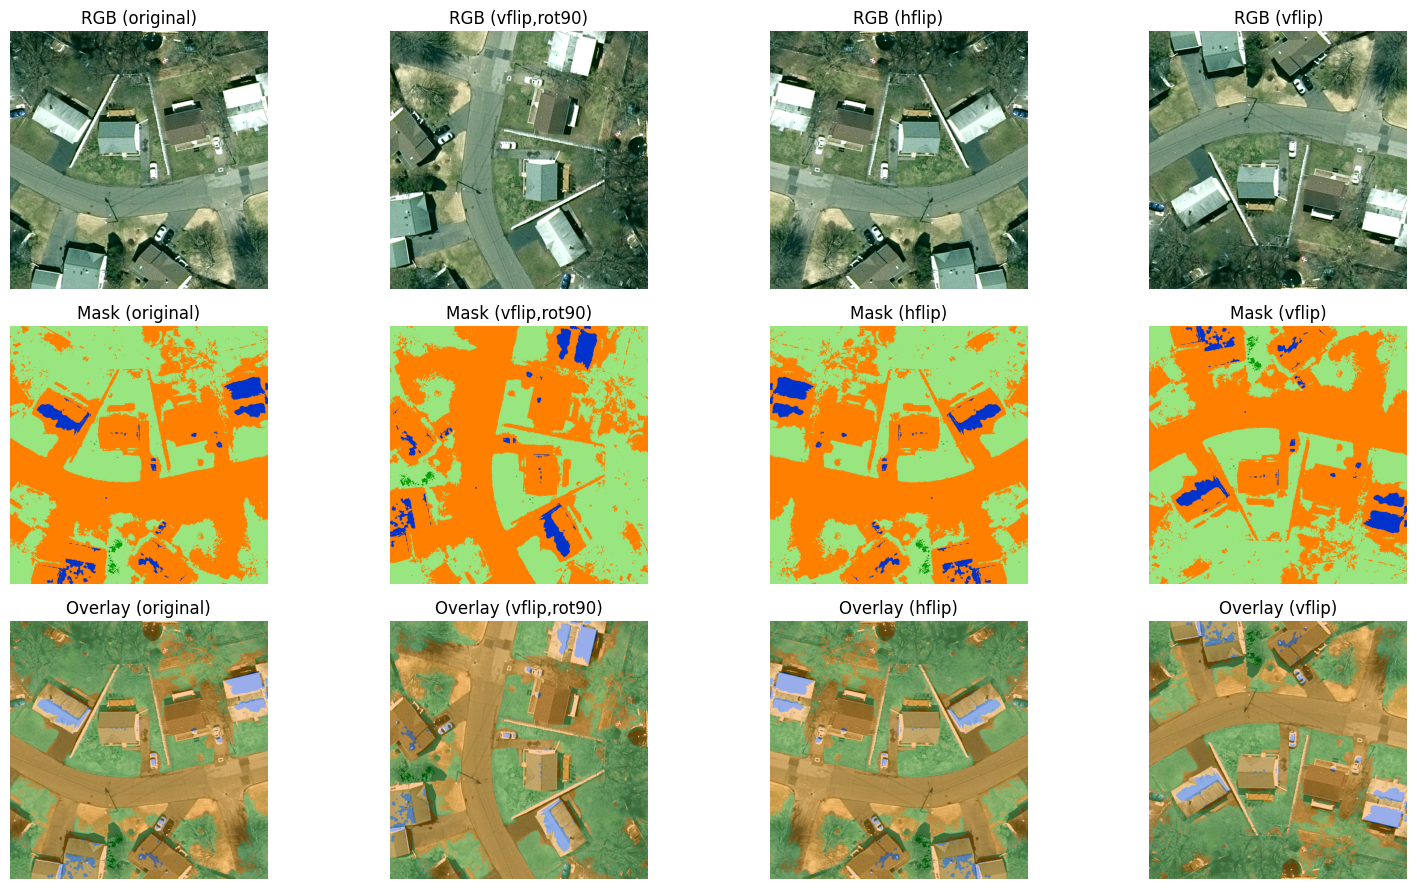

In [31]:
ndvi_colors = np.array([
    (0.0, 0.2, 0.8),  # 0: water (blue)
    (1.0, 0.5, 0.0),  # 1: bare/impervious (orange)
    (0.6, 0.9, 0.5),  # 2: sparse veg (light green)
    (0.0, 0.6, 0.0),  # 3: dense veg (dark green)
])
ndvi_cmap = ListedColormap(ndvi_colors)

# Pick one tile index to visualize (random)
idx = random.randint(0, len(image_paths) - 1)
print("Using tile index:", idx)
print("Image path:", image_paths[idx].name)

# Load base (non-augmented) RGB + mask as numpy arrays
base_img = np.array(Image.open(image_paths[idx]).convert("RGB")).astype("float32") / 255.0  # (H,W,3)
base_mask = np.array(Image.open(mask_paths[idx])).astype("int64")                           # (H,W)

def get_aug_version(dataset, img, mask):
    """
    Call the dataset's _augment once, and if we get 'none',
    call it again so we always show at least one transform.
    """
    img_aug, mask_aug, aug_label = dataset._augment(img.copy(), mask.copy())
    if aug_label == "none":
        img_aug, mask_aug, aug_label = dataset._augment(img.copy(), mask.copy())
    return img_aug, mask_aug, aug_label

# Collect original + 3 augmented versions
views = []

# Column 0 = original
views.append(("original", base_img, base_mask))

# Columns 1–3 = augmented versions
for k in range(3):
    img_a, mask_a, label_a = get_aug_version(FULL_DATASET, base_img, base_mask)
    views.append((label_a, img_a, mask_a))

num_cols = len(views)  # 4 columns: original + 3 augs

fig, axs = plt.subplots(3, num_cols, figsize=(4 * num_cols, 9))

for j, (label, img, mask) in enumerate(views):
    # Row 0: RGB
    axs[0, j].imshow(img)
    axs[0, j].set_title(f"RGB ({label})")
    axs[0, j].axis("off")

    # Row 1: NDVI class mask
    axs[1, j].imshow(mask, cmap=ndvi_cmap, vmin=0, vmax=3)
    axs[1, j].set_title(f"Mask ({label})")
    axs[1, j].axis("off")

    # Row 2: Overlay
    mask_rgb = ndvi_colors[mask]              # (H,W,3)
    overlay = 0.6 * img + 0.4 * mask_rgb
    overlay = np.clip(overlay, 0, 1)
    axs[2, j].imshow(overlay)
    axs[2, j].set_title(f"Overlay ({label})")
    axs[2, j].axis("off")

plt.tight_layout()
plt.show()

**Configuration**

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 4          # 0: water, 1: bare/impervious, 2: sparse veg, 3: dense veg
IN_CHANNELS = 3          # RGB
print("Using device:", DEVICE)


Using device: cuda


**U-NET Model**

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetSmall(nn.Module):
    def __init__(self, in_channels=3, n_classes=4):
        super().__init__()

        # --- Encoder ---
        self.enc1 = DoubleConv(in_channels, 32)   # in_channels -> 32
        self.pool1 = nn.MaxPool2d(2)              # 512 -> 256

        self.enc2 = DoubleConv(32, 64)            # 32 -> 64
        self.pool2 = nn.MaxPool2d(2)              # 256 -> 128

        self.enc3 = DoubleConv(64, 128)           # 64 -> 128
        self.pool3 = nn.MaxPool2d(2)              # 128 -> 64

        # --- Bottleneck ---
        self.bottleneck = DoubleConv(128, 256)    # 128 -> 256

        # --- Decoder ---
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)          # concat(128 up, 128 skip)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128, 64)           # concat(64 up, 64 skip)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64, 32)            # concat(32 up, 32 skip)

        # --- Output ---
        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)                 # (B, 32, 512, 512)
        x2 = self.enc2(self.pool1(x1))    # (B, 64, 256, 256)
        x3 = self.enc3(self.pool2(x2))    # (B, 128, 128, 128)

        x4 = self.bottleneck(self.pool3(x3))  # (B, 256, 64, 64)

        # Decoder
        u3 = self.up3(x4)                     # (B, 128, 128, 128)
        u3 = torch.cat([u3, x3], dim=1)       # (B, 256, 128, 128)
        d3 = self.dec3(u3)                    # (B, 128, 128, 128)

        u2 = self.up2(d3)                     # (B, 64, 256, 256)
        u2 = torch.cat([u2, x2], dim=1)       # (B, 128, 256, 256)
        d2 = self.dec2(u2)                    # (B, 64, 256, 256)

        u1 = self.up1(d2)                     # (B, 32, 512, 512)
        u1 = torch.cat([u1, x1], dim=1)       # (B, 64, 512, 512)
        d1 = self.dec1(u1)                    # (B, 32, 512, 512)

        logits = self.out_conv(d1)           # (B, n_classes, 512, 512)
        return logits

In [11]:
IN_CHANNELS = 3          # RGB
NUM_CLASSES = 4          # water, impervious, sparse veg, dense veg

model = UNetSmall(in_channels=IN_CHANNELS, n_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Optional: check total parameters
total_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Model parameters: {total_params:.2f}M")

Model parameters: 1.93M


**Metrics: IOU + DICE**

In [12]:
def compute_iou_and_dice(logits, masks, num_classes=4, eps=1e-6):
    """
    logits: (B, C, H, W)
    masks:  (B, H, W) with integer class labels
    Returns: (mean_iou, mean_dice) across classes that appear in GT.
    """
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)  # (B,H,W)

        preds = preds.view(-1)
        masks = masks.view(-1)

        iou_list = []
        dice_list = []

        for c in range(num_classes):
            pred_c = preds == c
            mask_c = masks == c

            inter = (pred_c & mask_c).sum().item()
            union = (pred_c | mask_c).sum().item()
            total = pred_c.sum().item() + mask_c.sum().item()

            if union == 0:
                continue

            iou = inter / (union + eps)
            dice = 2 * inter / (total + eps)

            iou_list.append(iou)
            dice_list.append(dice)

        if len(iou_list) == 0:
            return 0.0, 0.0

        return float(np.mean(iou_list)), float(np.mean(dice_list))

In [13]:
def compute_f1_and_accuracy(logits, masks, num_classes=4, eps=1e-6):
    """
    Computes:
      - mean F1 across classes present in GT
      - overall pixel accuracy
    for one batch of (logits, masks).
    """
    # logits: (B, C, H, W)
    # masks:  (B, H, W)  with integer class labels
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)  # (B,H,W)

        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)

        # Overall accuracy
        correct = (preds_flat == masks_flat).sum().item()
        total = masks_flat.numel()
        overall_acc = correct / (total + eps)

        # Per-class F1 over this batch
        f1_list = []
        for c in range(num_classes):
            pred_c = preds_flat == c
            mask_c = masks_flat == c

            tp = (pred_c & mask_c).sum().item()
            fp = (pred_c & ~mask_c).sum().item()
            fn = (~pred_c & mask_c).sum().item()

            denom = 2 * tp + fp + fn
            if denom == 0:
                # class not present in GT or preds in this batch
                continue

            f1_c = (2 * tp) / (denom + eps)
            f1_list.append(f1_c)

        if len(f1_list) == 0:
            mean_f1 = 0.0
        else:
            mean_f1 = float(np.mean(f1_list))

    return mean_f1, overall_acc

**Train/ validation loops**

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    running_f1 = 0.0
    running_acc = 0.0
    n_batches = 0

    for imgs, masks, _ in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # IoU & Dice
        iou, dice = compute_iou_and_dice(
            logits, masks, num_classes=NUM_CLASSES
        )
        running_iou += iou
        running_dice += dice

        # F1 & overall accuracy
        f1, acc = compute_f1_and_accuracy(
            logits, masks, num_classes=NUM_CLASSES
        )
        running_f1 += f1
        running_acc += acc

        n_batches += 1

    return (
        running_loss / n_batches,
        running_iou / n_batches,
        running_dice / n_batches,
        running_f1 / n_batches,
        running_acc / n_batches,
    )


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    running_f1 = 0.0
    running_acc = 0.0
    n_batches = 0

    with torch.no_grad():
        for imgs, masks, _ in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)

            running_loss += loss.item()

            iou, dice = compute_iou_and_dice(
                logits, masks, num_classes=NUM_CLASSES
            )
            running_iou += iou
            running_dice += dice

            f1, acc = compute_f1_and_accuracy(
                logits, masks, num_classes=NUM_CLASSES
            )
            running_f1 += f1
            running_acc += acc

            n_batches += 1

    return (
        running_loss / n_batches,
        running_iou / n_batches,
        running_dice / n_batches,
        running_f1 / n_batches,
        running_acc / n_batches,
    )

**Training Loop**

In [15]:
NUM_EPOCHS = 10
best_val_iou = 0.0

history = {
    "train_loss": [], "val_loss": [],
    "train_iou": [],  "val_iou": [],
    "train_dice": [], "val_dice": [],
    "train_f1": [],   "val_f1": [],
    "train_acc": [],  "val_acc": [],
}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_iou, train_dice, train_f1, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, DEVICE
    )
    val_loss, val_iou, val_dice, val_f1, val_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_iou"].append(train_iou)
    history["val_iou"].append(val_iou)
    history["train_dice"].append(train_dice)
    history["val_dice"].append(val_dice)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f" Train  – loss: {train_loss:.4f}, IoU: {train_iou:.4f}, "
        f"Dice: {train_dice:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}"
    )
    print(
        f" Val    – loss: {val_loss:.4f}, IoU: {val_iou:.4f}, "
        f"Dice: {val_dice:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}"
    )

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), "unet_small_best.pth")
        print(" ✅ New best model saved (val IoU improved).")


Epoch 1/10


 Train  – loss: 0.8181, IoU: 0.3634, Dice: 0.4644, F1: 0.4644, Acc: 0.6864
 Val    – loss: 0.6865, IoU: 0.3757, Dice: 0.4718, F1: 0.4718, Acc: 0.7080
 ✅ New best model saved (val IoU improved).

Epoch 2/10


 Train  – loss: 0.6495, IoU: 0.4041, Dice: 0.5037, F1: 0.5037, Acc: 0.7391
 Val    – loss: 0.6957, IoU: 0.3964, Dice: 0.4935, F1: 0.4935, Acc: 0.7255
 ✅ New best model saved (val IoU improved).

Epoch 3/10


 Train  – loss: 0.6077, IoU: 0.4237, Dice: 0.5230, F1: 0.5230, Acc: 0.7587
 Val    – loss: 0.6853, IoU: 0.3819, Dice: 0.4876, F1: 0.4876, Acc: 0.6833

Epoch 4/10


 Train  – loss: 0.5838, IoU: 0.4293, Dice: 0.5283, F1: 0.5283, Acc: 0.7654
 Val    – loss: 0.5431, IoU: 0.4525, Dice: 0.5451, F1: 0.5451, Acc: 0.7868
 ✅ New best model saved (val IoU improved).

Epoch 5/10


 Train  – loss: 0.5582, IoU: 0.4510, Dice: 0.5525, F1: 0.5525, Acc: 0.7754
 Val    – loss: 0.5485, IoU: 0.4505, Dice: 0.5398, F1: 0.5398, Acc: 0.7950

Epoch 6/10


 Train  – loss: 0.5195, IoU: 0.4626, Dice: 0.5625, F1: 0.5625, Acc: 0.7899
 Val    – loss: 0.4704, IoU: 0.4857, Dice: 0.5710, F1: 0.5710, Acc: 0.8214
 ✅ New best model saved (val IoU improved).

Epoch 7/10


 Train  – loss: 0.5081, IoU: 0.4643, Dice: 0.5602, F1: 0.5602, Acc: 0.7915
 Val    – loss: 0.4200, IoU: 0.4990, Dice: 0.5823, F1: 0.5823, Acc: 0.8315
 ✅ New best model saved (val IoU improved).

Epoch 8/10


 Train  – loss: 0.4779, IoU: 0.4784, Dice: 0.5741, F1: 0.5741, Acc: 0.8047
 Val    – loss: 0.5737, IoU: 0.4050, Dice: 0.4967, F1: 0.4967, Acc: 0.7569

Epoch 9/10


 Train  – loss: 0.4819, IoU: 0.4835, Dice: 0.5835, F1: 0.5835, Acc: 0.8035
 Val    – loss: 0.4403, IoU: 0.5106, Dice: 0.6088, F1: 0.6088, Acc: 0.8250
 ✅ New best model saved (val IoU improved).

Epoch 10/10


 Train  – loss: 0.4671, IoU: 0.4883, Dice: 0.5898, F1: 0.5898, Acc: 0.8069
 Val    – loss: 0.4748, IoU: 0.4699, Dice: 0.5616, F1: 0.5616, Acc: 0.8042


**Plots for Metrics**

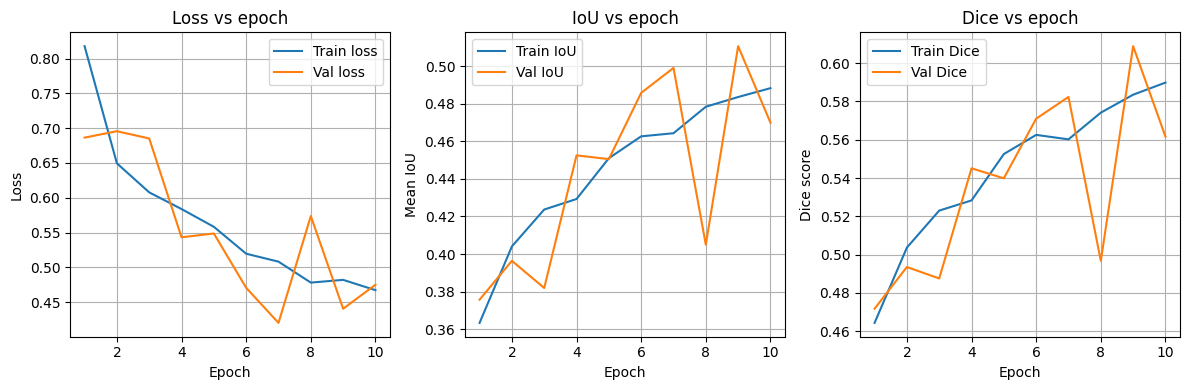

In [16]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# 1) Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()
plt.grid(True)

# 2) IoU
plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_iou"], label="Train IoU")
plt.plot(epochs, history["val_iou"], label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("IoU vs epoch")
plt.legend()
plt.grid(True)

# 3) Dice
plt.subplot(1, 3, 3)
plt.plot(epochs, history["train_dice"], label="Train Dice")
plt.plot(epochs, history["val_dice"], label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.title("Dice vs epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Plots for Metrics**

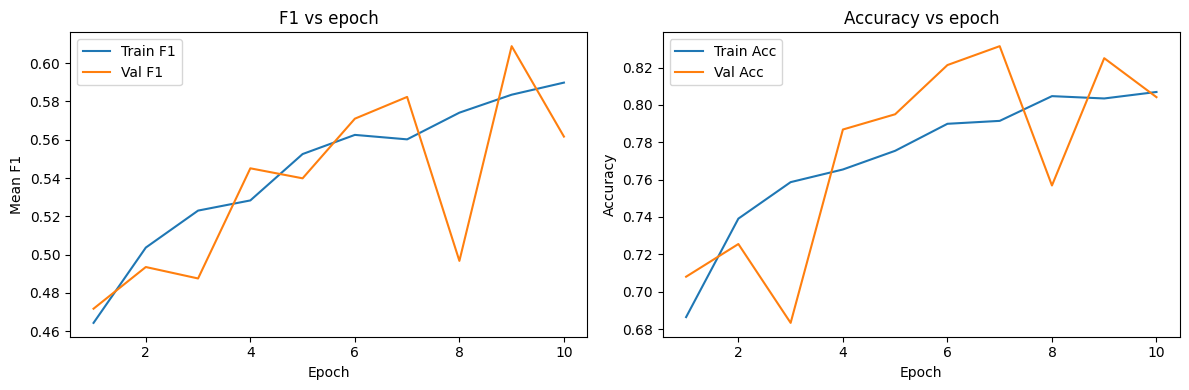

In [17]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,4))

# Mean F1
plt.subplot(1,2,1)
plt.plot(epochs, history["train_f1"], label="Train F1")
plt.plot(epochs, history["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Mean F1")
plt.title("F1 vs epoch")
plt.legend()

# Overall Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.tight_layout()
plt.show()


**Per-class F1 over the whole validation set**

In [18]:
def evaluate_per_class_f1(model, loader, device, num_classes=4, eps=1e-6):
    model.eval()
    tp = np.zeros(num_classes, dtype=np.int64)
    fp = np.zeros(num_classes, dtype=np.int64)
    fn = np.zeros(num_classes, dtype=np.int64)
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for imgs, masks, _ in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)

            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()

            for c in range(num_classes):
                pred_c = preds == c
                mask_c = masks == c

                tp[c] += (pred_c & mask_c).sum().item()
                fp[c] += (pred_c & ~mask_c).sum().item()
                fn[c] += (~pred_c & mask_c).sum().item()

    per_class_f1 = []
    for c in range(num_classes):
        denom = 2 * tp[c] + fp[c] + fn[c]
        if denom == 0:
            per_class_f1.append(float("nan"))
        else:
            per_class_f1.append((2 * tp[c]) / (denom + eps))

    mean_f1 = float(np.nanmean(per_class_f1))
    overall_acc = total_correct / (total_pixels + eps)

    return per_class_f1, mean_f1, overall_acc


In [24]:
CLASS_NAMES = ["water", "impervious", "sparse veg", "dense veg"]

def formatted_print_f1(per_class_f1, mean_f1, overall_acc):
    print("\nPer-class F1 Scores:")
    for i, f1 in enumerate(per_class_f1):
        print(f"• {CLASS_NAMES[i]:12s}: {f1:.4f}")
    print(f"\nMean F1: {mean_f1:.4f}")
    print(f"Overall Accuracy: {overall_acc:.4f}")

formatted_print_f1(per_class_f1, mean_f1, overall_acc)



Per-class F1 Scores:
• water       : 0.8502
• impervious  : 0.8210
• sparse veg  : 0.7509
• dense veg   : 0.0004

Mean F1: 0.6056
Overall Accuracy: 0.8044


Model 1: Visual Predictions

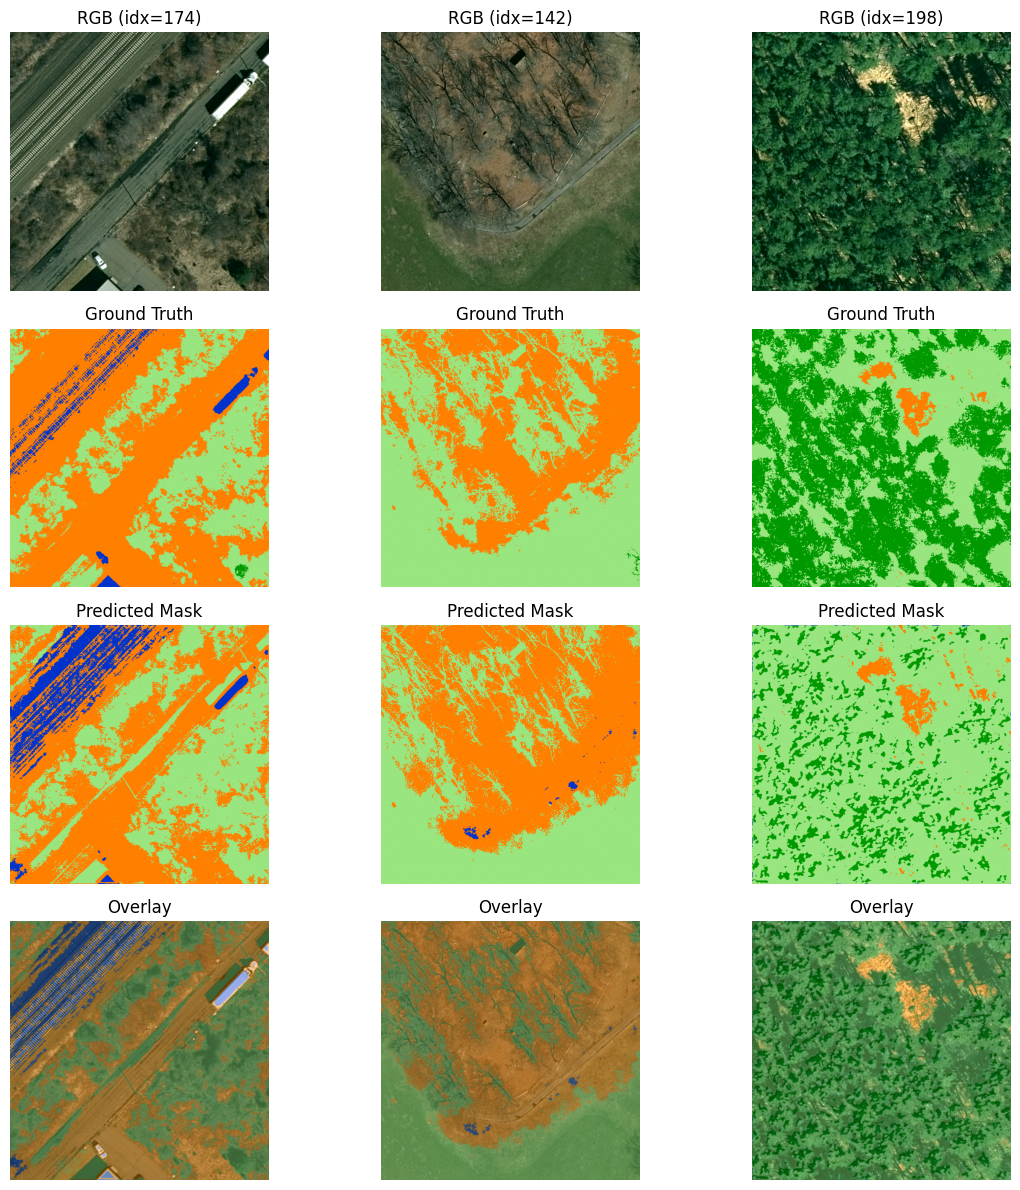

In [33]:
N = 3
rand_idxs = random.sample(range(len(val_dataset)), N)

# Load best checkpoint
best_model = UNetSmall(in_channels=IN_CHANNELS, n_classes=NUM_CLASSES).to(DEVICE)
best_model.load_state_dict(torch.load("unet_small_best.pth", map_location=DEVICE))
best_model.eval()

ndvi_colors = np.array([
    (0.0, 0.2, 0.8),  # 0: water
    (1.0, 0.5, 0.0),  # 1: impervious/bare
    (0.6, 0.9, 0.5),  # 2: sparse veg
    (0.0, 0.6, 0.0),  # 3: dense veg
])

fig, axs = plt.subplots(4, N, figsize=(4 * N, 12))

for col, idx in enumerate(rand_idxs):
    # Load a single item from the validation dataset
    img, gt, _ = val_dataset[idx]

    img_t = img.unsqueeze(0).to(DEVICE)  # add batch dim
    gt_t  = gt.to(DEVICE)

    with torch.no_grad():
        logits = best_model(img_t)
        pred = torch.argmax(logits, dim=1)[0]  # (H, W)

    # Convert to numpy
    img_np  = img.permute(1,2,0).numpy()
    gt_np   = gt.numpy()
    pred_np = pred.cpu().numpy()

    # Colorize masks
    gt_rgb   = ndvi_colors[gt_np]
    pred_rgb = ndvi_colors[pred_np]
    overlay  = np.clip(0.6 * img_np + 0.4 * pred_rgb, 0, 1)

    # --- Plot ---
    axs[0, col].imshow(img_np)
    axs[0, col].set_title(f"RGB (idx={idx})")
    axs[0, col].axis("off")

    axs[1, col].imshow(gt_rgb)
    axs[1, col].set_title("Ground Truth")
    axs[1, col].axis("off")

    axs[2, col].imshow(pred_rgb)
    axs[2, col].set_title("Predicted Mask")
    axs[2, col].axis("off")

    axs[3, col].imshow(overlay)
    axs[3, col].set_title("Overlay")
    axs[3, col].axis("off")

plt.tight_layout()
plt.show()